# AdEase
<br>

- Ad Ease is an ads and marketing based company helping businesses elicit maximum clicks @ minimum cost. AdEase is an ad infrastructure to help businesses promote themselves easily, effectively, and economically
<br>

- The interplay of 3 AI modules - Design, Dispense, and Decipher, come together to make it this an end-to-end 3 step process digital advertising solution for all.
<br>

Dataset link - https://drive.google.com/drive/folders/1mdgQscjqnCtdg7LGItomyK0abN6lcHBb
## Problem Statement - 
- You are working in the Data Science team of Ad ease trying to understand the per page view report for different wikipedia pages for 550 days
<br>

- You have to forecast the number of views forecasting the number of views so that you can predict and optimize the ad placement for your clients 
<br>

- You are provided with the data of 145k wikipedia pages and daily view count for each of them
<br>

- Your clients belong to different regions and need data on how their ads will perform on pages in different languages.

In [286]:
import numpy as np

import pandas as pd

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

import seaborn as sns

import statsmodels.api as sm

import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Basic data exploration 

In [2]:
df = pd.read_csv("train_1.csv")

- Time series data stored in df

In [3]:
df2 = pd.read_csv("Exog_Campaign_eng")

- Exogenous data stored in df2

In [4]:
df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


- Need to extract language from the "Page" column as our SARIMAX model will need that

In [5]:
df2.head()

,Exog
0,0
1,0
2,0
3,0
4,0


In [6]:
df.shape

(145063, 551)

- Time series data has 145063 rows and 554 columns

In [7]:
df2.shape

(550, 1)

- Exogenous variable data has 550 rows and 1 column

In [8]:
df.isnull().any(axis=1).sum()

27786

- Time series data has 27786 null values 

In [9]:
df2.isnull().any(axis=0).sum()

0

# Data formatting


#### Separating different values from  the column page - title, language, access type, and access origin.

In [10]:
temp = df["Page"].str.extract(r"wikipedia\.org_([A-Za-z-_]+)")[0]
temp = temp.str.split("_", expand=True)
temp = pd.concat([temp,df], axis=1).rename(columns={0:"access_type",1:"access_origin"})
lang = temp["Page"].str.extract(r"_([A-Za-z]{2}).wikipedia.org_")
temp = pd.concat([lang,temp], axis=1).rename(columns={0:"language"})
temp["Page"]=temp["Page"].str.replace(r"(_[A-Za-z]{2}.wikipedia.[A-Za-z_-]+)","",regex=True)
temp = temp.rename(columns={"Page":"title"})
df = temp.copy(); df.head()

,language,access_type,access_origin,title,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,zh,all-access,spider,2NE1,18.0,11.0,5.0,13.0,14.0,9.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,zh,all-access,spider,2PM,11.0,14.0,15.0,18.0,11.0,13.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,zh,all-access,spider,3C,1.0,0.0,1.0,1.0,0.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,zh,all-access,spider,4minute,35.0,13.0,10.0,94.0,4.0,26.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,zh,all-access,spider,52_Hz_I_Love_You,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


- Title, language, access type, and access origin now sepearted from the orignal column

#### Creating a language dictionary to map with all the acronyms

In [11]:
language_dict = {"es":"spanish", "zh":"chinese", "ru":"russian", "fr":"french", "de":"german", "en":"english", "ja":"japanese"}
df["language"]=df["language"].map(language_dict)

In [12]:
df.head()

,language,access_type,access_origin,title,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,chinese,all-access,spider,2NE1,18.0,11.0,5.0,13.0,14.0,9.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,chinese,all-access,spider,2PM,11.0,14.0,15.0,18.0,11.0,13.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,chinese,all-access,spider,3C,1.0,0.0,1.0,1.0,0.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,chinese,all-access,spider,4minute,35.0,13.0,10.0,94.0,4.0,26.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,chinese,all-access,spider,52_Hz_I_Love_You,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


# Checking null values and understanding their reason

In [13]:
print(df.isnull().any(axis=1).sum()/df.shape[0]*100,"% null rows")

25.477206455126396 % null rows


- As we can see around 25% percent of our values are missing

<Axes: xlabel='title'>

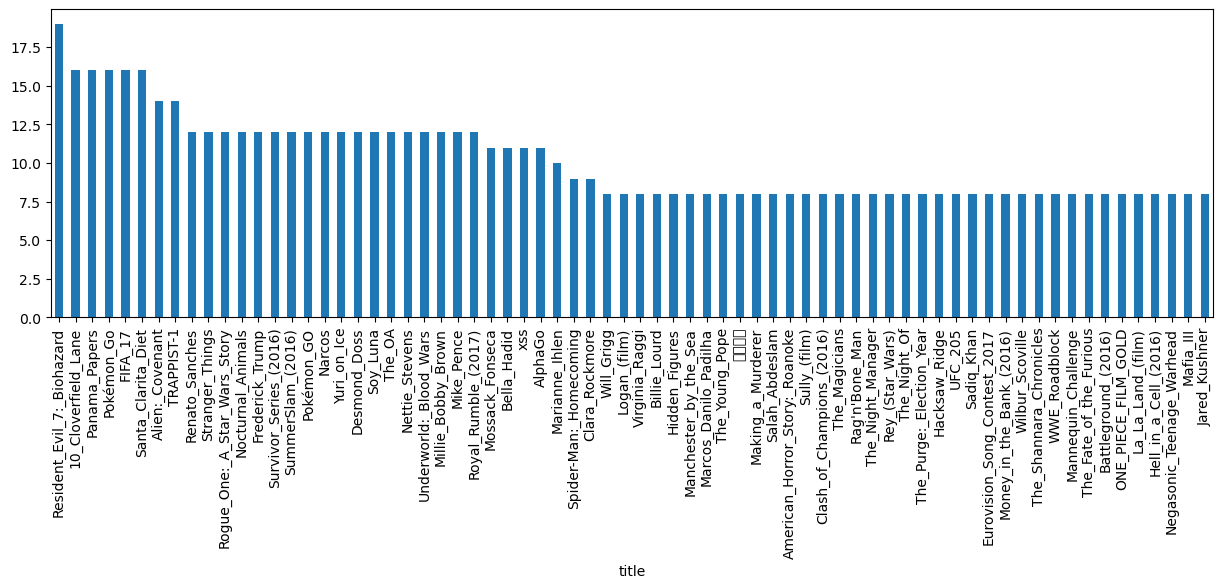

In [14]:
df[df.isnull().any(axis=1)]["title"].value_counts()[:70].plot(kind="bar", figsize=(15,4))

- Null rows have mostly gaming category titles

In [15]:
df.dropna(inplace=True)

- Dropping null values 

In [16]:
df.shape

(108105, 554)

- Fianl shape after dropping null values

# Exploratory Data Analysis

#### Count of daily views per language

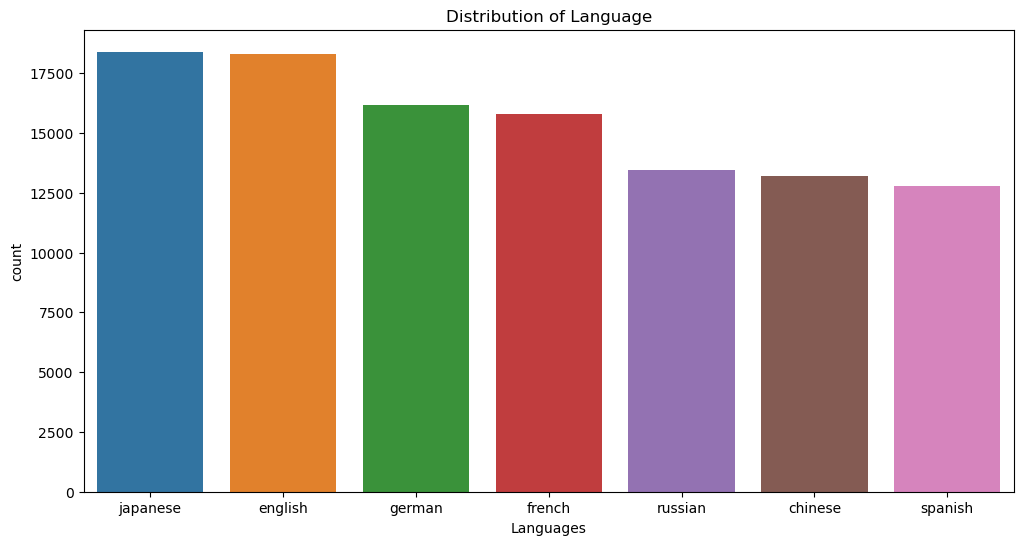

In [17]:
plt.figure(figsize=(12,6))

sns.countplot(x='language',data=df,order=df['language'].value_counts().index)

plt.title("Distribution of Language")

plt.xlabel("Languages")

plt.show()

 - English and Japanese articles seem to have highest frequency in our data 

#### Acess type dritibution pie chart

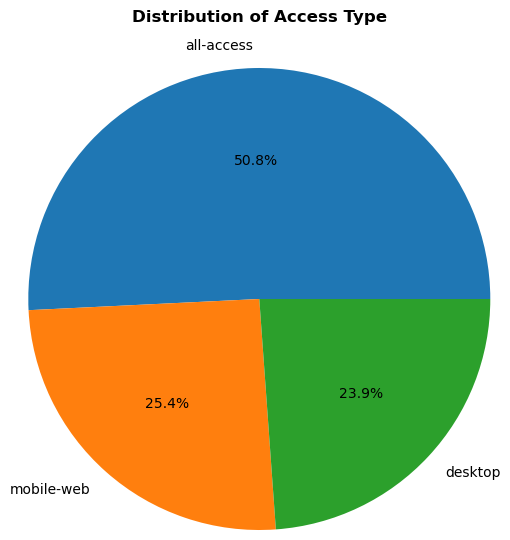

In [18]:
plt.figure(figsize=(6, 5))

plt.title("Distribution of Access Type", fontweight='bold', y=1.2)

plt.pie(x=df['access_type'].value_counts().values, labels=df['access_type'].value_counts().index, radius=1.5, autopct='%0.1f%%')

plt.show()

 - All-acess seemes to be the highest used followed by mobile and than desktop

- Acess origin distribution pie chart

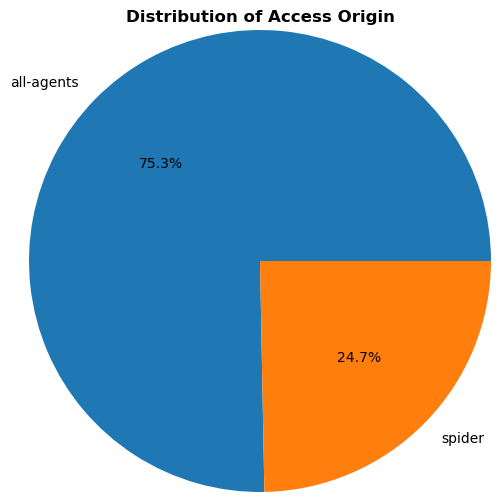

In [19]:
plt.figure(figsize=(6, 5))

plt.title("Distribution of Access Origin", fontweight='bold', y=1.1)

plt.pie(x=df['access_origin'].value_counts().values,labels=df['access_origin'].value_counts().index,radius=1.5,autopct='%0.1f%%')

plt.show()

- All agents seems to heavily dominate spider  

# Converting the data to a format that can be fed to the Arima model

In [20]:
df.head(2)

,language,access_type,access_origin,title,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,chinese,all-access,spider,2NE1,18.0,11.0,5.0,13.0,14.0,9.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,chinese,all-access,spider,2PM,11.0,14.0,15.0,18.0,11.0,13.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0


In [21]:
df.columns[4:]

Index(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04', '2015-07-05',
       '2015-07-06', '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10',
       ...
       '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25', '2016-12-26',
       '2016-12-27', '2016-12-28', '2016-12-29', '2016-12-30', '2016-12-31'],
      dtype='object', length=550)

In [22]:
df_group = df.groupby(["language"])[df.columns[4:]].mean()

- Taking average daily view for every date and every language 

In [23]:
data_TimeSeries = df_group.T

In [24]:
data_TimeSeries.index = np.vectorize(lambda x: np.datetime64(x))(data_TimeSeries.index)

- Converting index to datetime format

# Time Series plot : all 7 languages

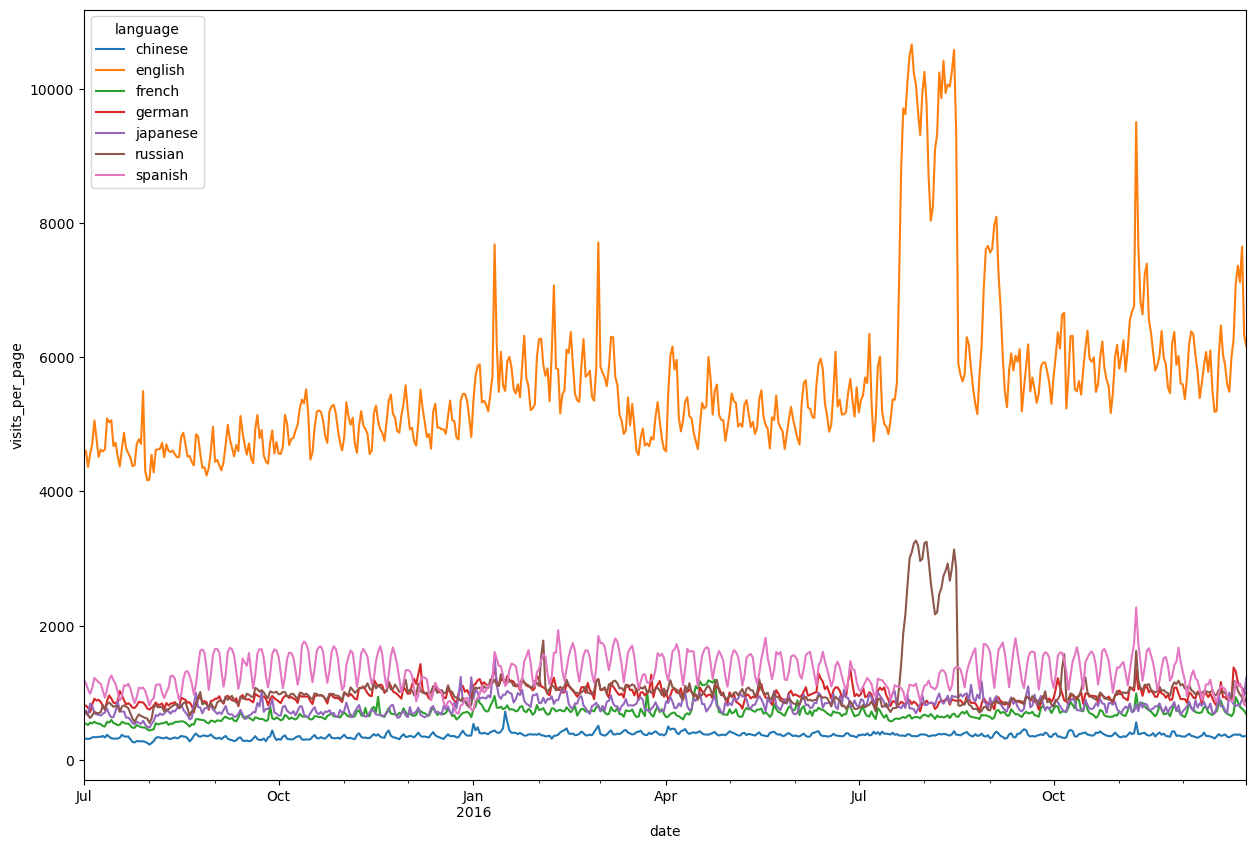

In [25]:
data_TimeSeries.plot(figsize=(15,10))

plt.xlabel("date")

plt.ylabel("visits_per_page")

plt.show()

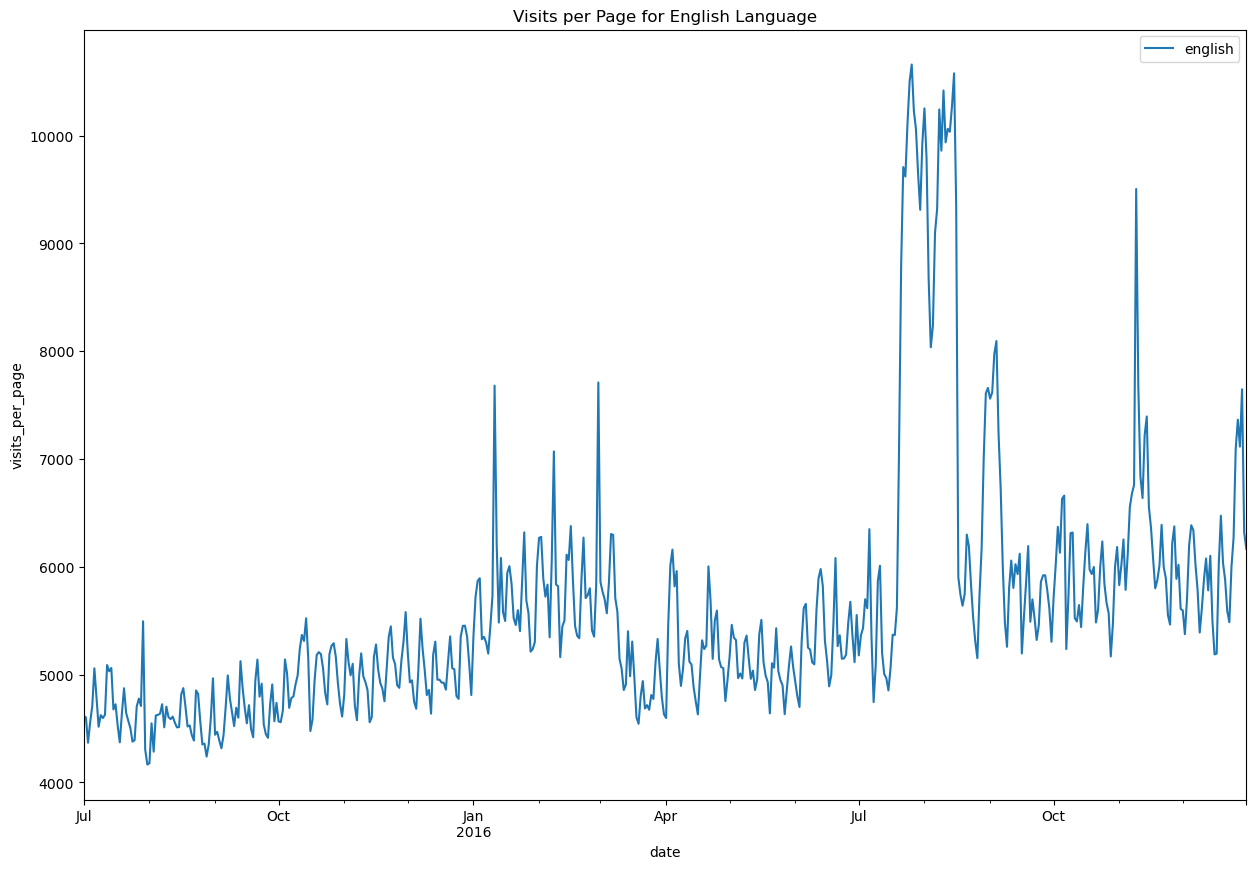

In [26]:
english_data = data_TimeSeries['english']

english_data.plot(figsize=(15, 10), label='english')

plt.xlabel("date")

plt.ylabel("visits_per_page")

plt.title("Visits per Page for English Language")

plt.legend()

plt.show()

<Axes: xlabel='language'>

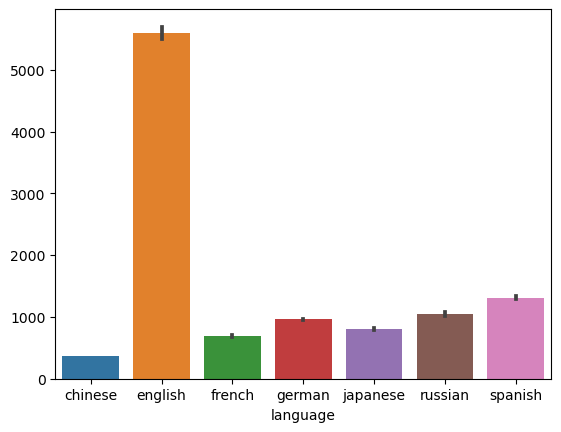

In [27]:
sns.barplot(data_TimeSeries)

- English is the language which has highest views than any other languages
- Chinese language has the lowest number of views
- Spanish has 2nd highest views, followed by German and Russian

# Checking the stationarity using Augmented Dickey Fuller test

- The Dickey-Fuller test, named after economists David Dickey and Wayne Fuller, is a statistical test used to determine whether a unit root is present in a time series dataset.
<br>

- A unit root is a characteristic of a time series that indicates it is non-stationary, meaning its statistical properties, such as the mean and variance, are not constant over time. Non-stationary time series data often exhibit trends, cycles, or other patterns that change over time.
<br>

- The presence of a unit root can make time series data difficult to analyze and model because it violates the assumptions of many statistical techniques like SARIMAX that require stationary data.
<br>

- The Dickey-Fuller test helps in determining whether a time series has a unit root by testing the **null hypothesis that the time series is not stationary** against the alternative hypothesis that it is stationary.
<br>

- The test statistic from the Dickey-Fuller test is compared to a  **p-values (0.05)** from a specific distribution to determine whether to reject the null hypothesis. If the test statistic is less than the critical value, the null hypothesis is rejected, indicating the time series is stationary. If the test statistic is greater than the critical value, the null hypothesis is not rejected, suggesting the presence of a unit root and non-stationarity in the time series.
<br>

- The Dickey-Fuller test is widely used in econometrics, finance, and other fields for testing the stationarity of time series data before applying statistical models or analysis techniques.

### Performing the AD Fuller test for the columns

In [28]:
for col in data_TimeSeries.columns:
    
    pvalue = sm.tsa.stattools.adfuller(data_TimeSeries[col])[1]
    
    if pvalue >= 0.05:
        
        print(col,": Sequence is NOT stationary")
        print("\n")
        
    else:
        
        print(col, ": Sequence is stationary")
        print("\n")

chinese : Sequence is NOT stationary


english : Sequence is NOT stationary


french : Sequence is stationary


german : Sequence is NOT stationary


japanese : Sequence is stationary


russian : Sequence is stationary


spanish : Sequence is stationary




- Chinese , English and German language columns are not stationary indicating change of variance over time
<br>

- French , Japanese , Russian and spanish columns are stationary

# Making the time series stationary



##  Through Decomposition and Differencing the time-series


### Removing trend and seasonality with decomposition for the "English language column"


#### In statsmodels, the seasonal decomposition function (seasonal_decompose) is used to remove trend and seasonality from a time series. Here's how it works:
<br>

- Trend Removal :
<br>

- The function identifies the trend component of the time series by applying a moving average filter or a locally weighted regression (LOESS) to smooth out the data
<br>

- This smoothed trend component represents the long-term, systematic pattern in the data
<br>

- After identifying the trend, it is subtracted from the original time series to remove the trend component
<br>

- Seasonality Removal :
<br>

- After removing the trend, the function identifies the seasonal component of the time series
<br>

- Seasonality refers to repeating patterns or cycles that occur at fixed intervals, such as daily, weekly, or yearly etc..
<br>

- The function estimates the seasonal component by averaging out the seasonal fluctuations over multiple periods
<br>

- Once identified, the seasonal component is subtracted from the detrended time series to remove the seasonal patterns
<br>

- Residual Component:
<br>

- After removing the trend and seasonal components, the residual component represents the remaining variation in the data that cannot be explained by the trend or seasonality


In [29]:
model_decompose = sm.tsa.seasonal_decompose(data_TimeSeries["english"], model='additive')

- Decomposing the time series through additive decomposition 
<br>

- sm.tsa.seasonal_decompose A object with seasonal, trend, and residual attributes

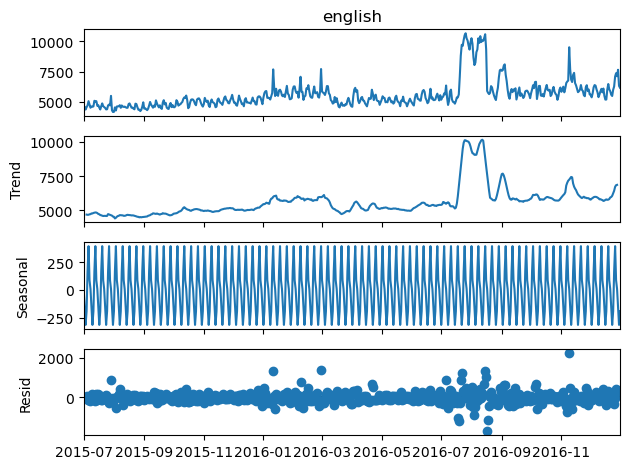

In [30]:
temp = model_decompose.plot()

- We can observe trend and seasonality from the above plots

<Axes: >

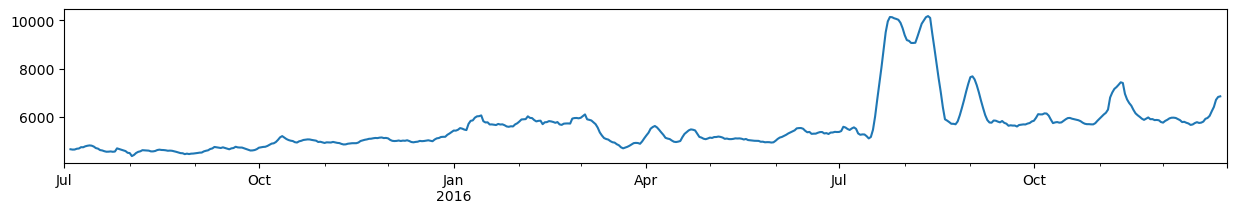

In [31]:
model_decompose.trend.plot(figsize=(15,2))


- Trend for the english language column

<Axes: >

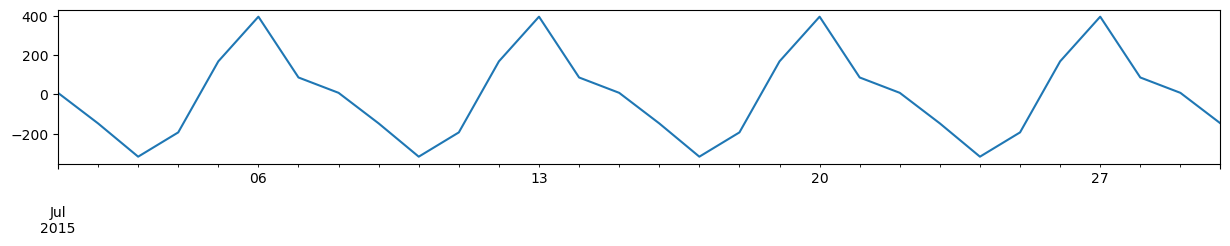

In [32]:
model_decompose.seasonal[:30].plot(figsize=(15,2))


- Seasonality for the english language column

<Axes: ylabel='Density'>

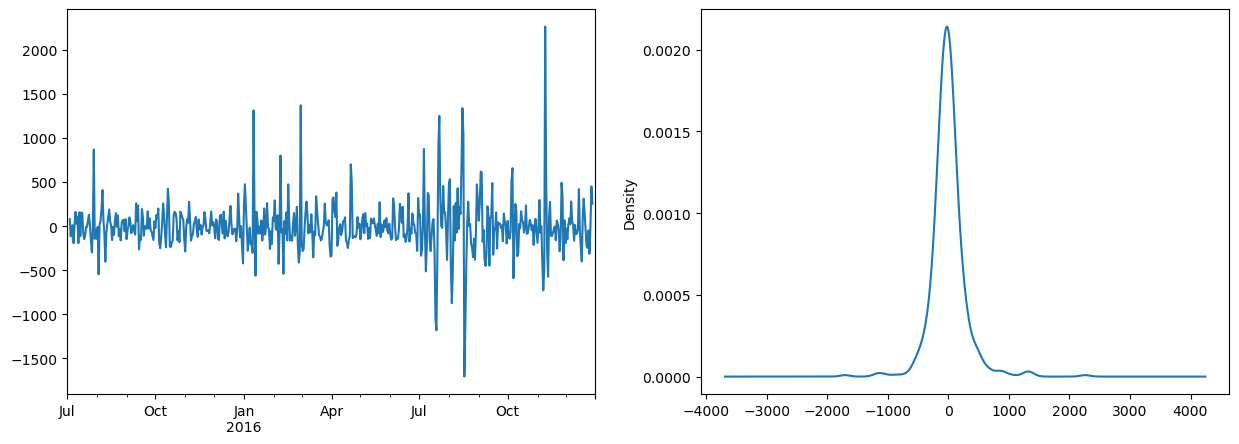

In [33]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

model_decompose.resid.plot()

plt.subplot(1,2,2)

model_decompose.resid.plot(kind="kde")

- residuals have no pattern and the mean ~ 0 which is an indicator that no pattern is still left in the data
<br>

- Residuals = Observed − ( Trend + Seasonal )

In [35]:
residuals = model_decompose.resid

residuals_no_nan = residuals[~np.isnan(residuals)]

adf_result = sm.tsa.stattools.adfuller(residuals_no_nan)

print("p-value:", adf_result[1])

p-value: 1.9704310103978326e-19


- As p-value < 0.05 , model_decompose is stationary

# Differencing : time-series data "English language column"


- Differencing is a method used in time series analysis to transform a non-stationary time series into a stationary one
<br>

- It involves computing the differences between consecutive observations in the series
<br>

- This technique helps remove trends or seasonality present in the data, making it easier to model and analyze using statistical techniques that assume stationarity. For example SARIMAX

<Axes: >

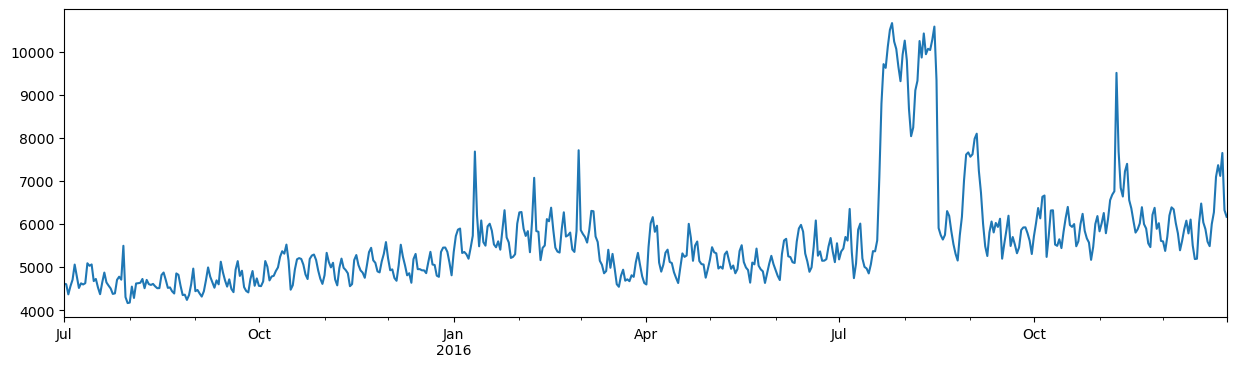

In [44]:
data_TimeSeries["english"].plot(figsize=(15,4))

- Original data with clear trend and seasonality

<Axes: >

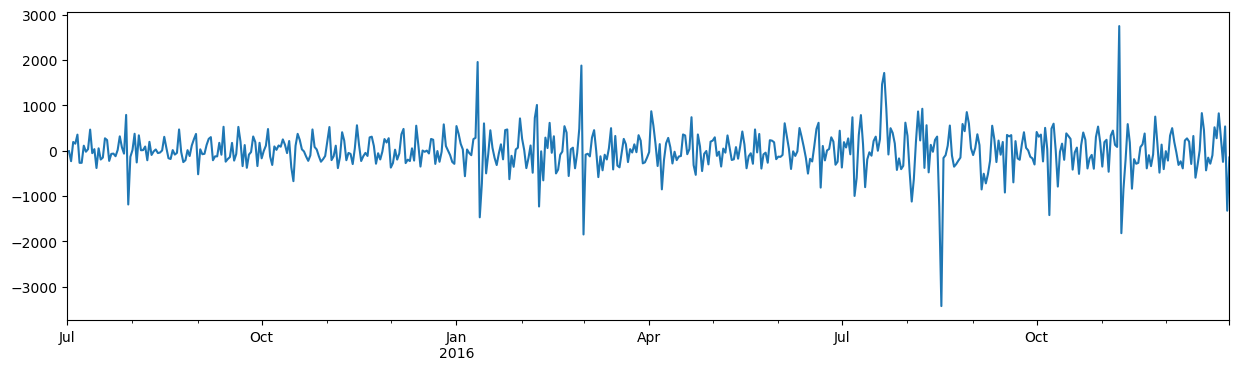

In [37]:
data_TimeSeries["english"].diff().plot(figsize=(15,4))

- Data after differencing , trend and seasonality is removed and can be visually confirmed

In [40]:
sm.tsa.stattools.adfuller(data_TimeSeries["english"].diff().dropna())[1]

6.787858479121312e-13

- As the p-value << 0.05 , differencing has been able to make the time series stationary

# Plotting the ACF and PACF plots


The Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) are statistical tools used in time series analysis to understand the correlation structure within a sequence of observations. Here are concise definitions of each :

**Autocorrelation Function (ACF) :**

- The ACF measures the correlation between a time series and its lagged values at various lags
- It quantifies the linear relationship between the observations of a time series at different points in time
- ACF plots typically display correlation coefficients against the lag, showing how the current observation is correlated with its past values at different time lags
<br>

**Partial Autocorrelation Function (PACF) :**

- The PACF measures the correlation between a time series and its lagged values, while controlling for the values of the intermediate lags
- It helps identify the direct effect of a specific lag on the current observation after removing the effects of the intermediate lags
- PACF plots typically display partial correlation coefficients against the lag, allowing analysts to identify the significant lags in the time series that influence its behavior
<br>

- Both ACF and PACF are essential tools in time series analysis and are commonly used to identify the underlying patterns and dependencies in the data. They play a crucial role in model selection, parameter estimation, and diagnostic checking, particularly in models like autoregressive integrated moving average (ARIMA) and seasonal ARIMA (SARIMA).

In [64]:
english = data_TimeSeries.english.values

- Getting the english language values from our original dataframe

<Axes: >

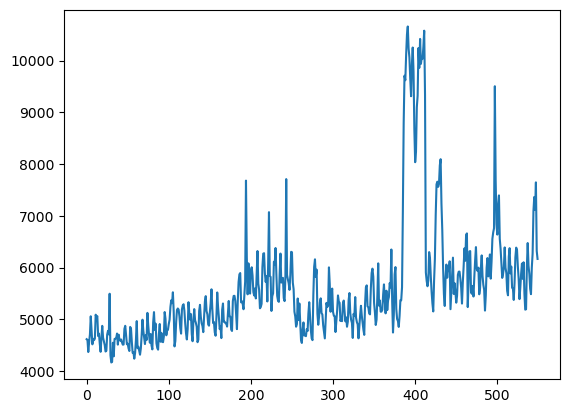

In [65]:
sns.lineplot(english)

- As expected data is not stationary so let us convert it to stationary as PACF and ACF plots require stationary data

<Axes: >

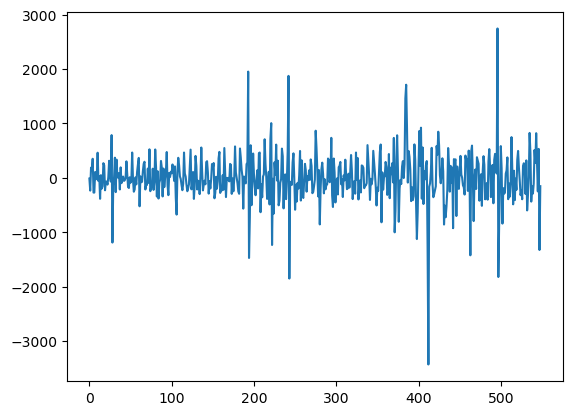

In [73]:
decomposition =np.diff(english)
sns.lineplot(decomposition)

- Data looks stationary. Let us now perform the adfuller test alaso

In [75]:
sm.tsa.stattools.adfuller(decomposition)[1]

6.787858479121312e-13

- P-value < 0.05 hence data is stationary

## Plotting the ACF plot

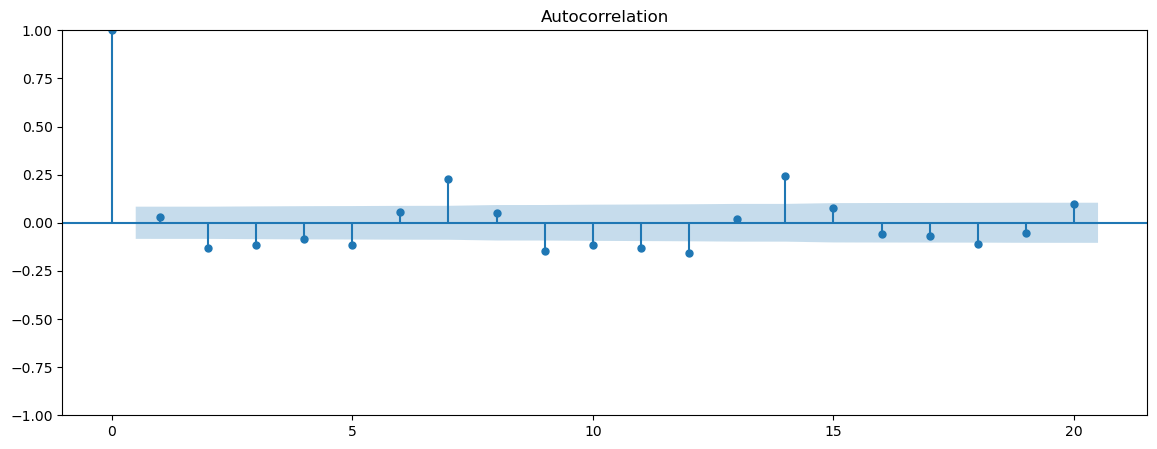

In [84]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

pacf=plot_acf(decomposition,lags=20)

pacf.set_size_inches((14, 5))


## Plotting the PACF plot

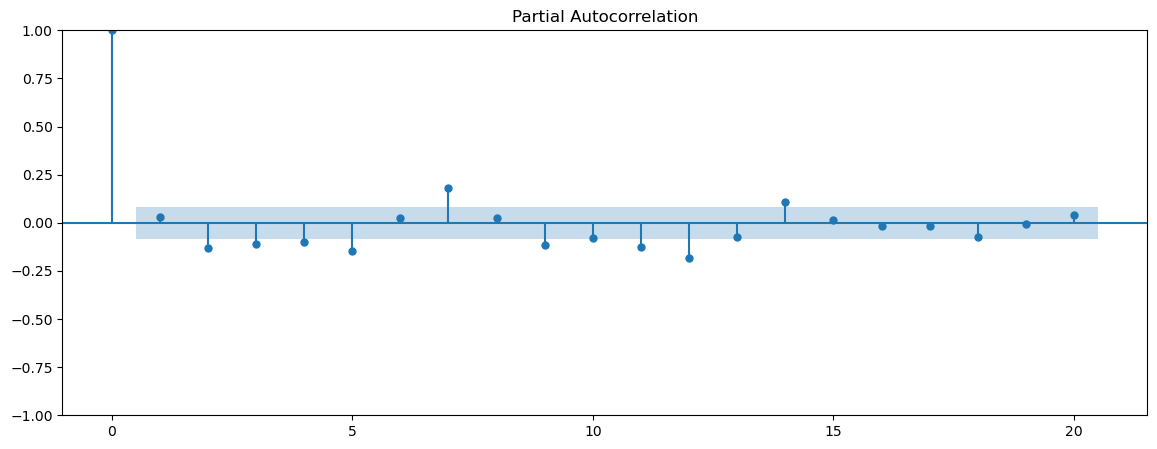

In [87]:
pacf=plot_pacf(decomposition,lags=20)
pacf.set_size_inches((14, 5))

# Modelling


## ARIMA Model

ARIMA stands for AutoRegressive Integrated Moving Average. It's a widely used time series forecasting model that combines three key components: autoregression (AR), differencing (I), and moving average (MA). Here's a concise definition of ARIMA:

- AutoRegressive (AR): The autoregressive component of ARIMA represents the relationship between the current observation and a certain number of lagged observations (i.e., its own past values). An autoregressive model uses past observations in a regression equation to predict future values. The order of the autoregressive component, denoted as p, indicates the number of lagged observations included in the model.
<br>

- Integrated (I): The integrated component of ARIMA represents the differencing of the time series data to make it stationary. Differencing involves subtracting each observation from its previous observation. The order of differencing, denoted as d, indicates the number of times differencing is performed to achieve stationarity.
<br>

- Moving Average (MA): The moving average component of ARIMA represents the relationship between the current observation and a residual error term based on past errors. A moving average model uses past forecast errors in a regression equation to predict future values. The order of the moving average component, denoted as q, indicates the number of lagged forecast errors included in the model.
<br>
- Together, the ARIMA model combines these three components to model and forecast time series data. The notation ARIMA(p, d, q) specifies the orders of the autoregressive, differencing, and moving average components, respectively. ARIMA models are widely used in various fields for time series forecasting, including finance, economics, and meteorology, among others.








In [185]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


from pandas import DataFrame

from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae,
    mean_absolute_percentage_error as mape
    
)

### Creating the train-test split

In [134]:
train_x = data_TimeSeries.loc[data_TimeSeries.index[:-61]]

test_x = data_TimeSeries.loc[data_TimeSeries.index[-61:]]

train_x.shape,test_x.shape

((489, 7), (61, 7))

### Creating and training the Arima model

In [135]:
train_x["english"].head()

2015-07-01    4614.991857
2015-07-02    4601.564792
2015-07-03    4366.968246
2015-07-04    4555.580150
2015-07-05    4707.019183
Name: english, dtype: float64

- Sequence is not stationary

In [105]:
sm.tsa.stattools.adfuller(train_x["english"].diff(1).dropna())[1]

4.2541406875698374e-11

- Hence our value for d will be 1 as we are getting stationary time series at 1

### Grid Search

In [231]:
ar = [2,3,4,5,6,7,8,9]
ma = [1,2,3,4,5,6]

In [233]:
result = []
for p in ar:
    for q in ma:
        model_temp = ARIMA(train_x["english"], order=(p, 1, q))
        model_temp = model_temp.fit()
        result.append([p,q,round(mape(test_x["english"], model_temp.forecast(steps=61)), 3),round(mse(test_x["english"],model_temp.forecast(steps=61)),3)])

In [234]:
pd.DataFrame(result, columns=["p","q","mape","mse"]).sort_values(by="mape",ascending=True).head(10)

,p,q,mape,mse
2,2,3,0.067,579372.933
9,3,4,0.068,581500.370
25,6,2,0.068,600653.584
39,8,4,0.068,592979.474
38,8,3,0.069,603808.240
5,2,6,0.069,607119.034
26,6,3,0.069,612240.437
32,7,3,0.069,606567.346
11,3,6,0.069,605670.195
13,4,2,0.069,618064.347


- p = 2 and q = 3 is giving us the best values of MAPE and MSE

<Axes: >

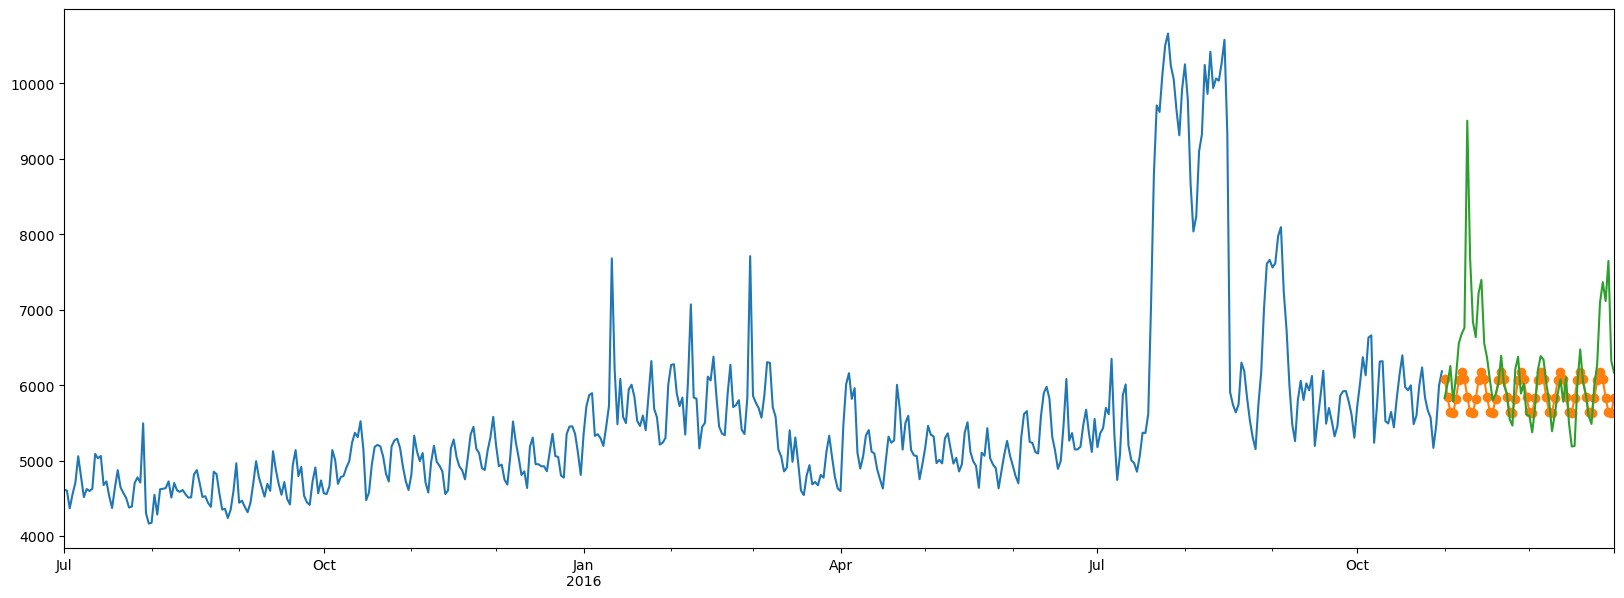

In [258]:
model_temp = ARIMA(train_x["english"], order=(2, 1, 3))
model_temp = model_temp.fit()
forecast = model_temp.forecast(steps=61)
plt.figure(figsize = (20,7))
train_x["english"].plot()
forecast.plot(label='Forecast',style='-o')
test_x["english"].plot()

- With high MAPE and through this plot we can say that the ARIMA model is performing very bad
<br>

- This is because of the fact that our data has seasonality and ARIMA does not consider seasonality while making the forecast model

# SARIMAX model

The SARIMAX model is a statistical method used for time series forecasting, particularly when the data exhibit seasonality. It extends the ARIMA (AutoRegressive Integrated Moving Average) model by incorporating additional seasonal and exogenous variables.

- AutoRegressive Integrated Moving Average (ARIMA): The SARIMAX model builds upon the ARIMA framework, which consists of three key components:
<br>
- AutoRegressive (AR) Component: This component models the relationship between the current observation and a specified number of lagged observations of the time series. The order of the AR component (denoted as p) indicates the number of lagged observations included in the model.
<br>

- Integrated (I) Component: This component represents the differencing of the time series data to achieve stationarity. Differencing involves subtracting each observation from its previous observation. The order of differencing (denoted as d) indicates the number of times differencing is performed.
<br>

- Moving Average (MA) Component: This component models the relationship between the current observation and a specified number of lagged forecast errors. The order of the MA component (denoted as q) indicates the number of lagged forecast errors included in the model.
<br>

- Seasonality: In addition to the ARIMA components, the SARIMAX model accounts for seasonal patterns in the data. It includes seasonal ARIMA components (SARIMA) to capture the periodic fluctuations that occur at regular intervals within the time series. The seasonal components include seasonal auto-regression (SAR), seasonal differencing (seasonal differencing order denoted as D), and seasonal moving average (SMA).
<br>

- exogenous Factors (X): The SARIMAX model allows for the inclusion of exogenous variables, which are external factors that may influence the time series but are not directly modeled by the ARIMA components. These exogenous variables can be incorporated into the model to improve forecast accuracy by accounting for additional explanatory factors.
<br>

In summary, the SARIMAX model is a powerful tool for time series forecasting that combines the ARIMA framework with seasonal components and exogenous variables. It provides a flexible and comprehensive approach to modeling and forecasting time series data, particularly those with seasonal patterns and external influences.

### Grid Search

In [259]:
ar_seasonal = [0,1,2]
ma_seasonal = [0,1,2]
exog_forecast = df2 
result = []
for P in ar_seasonal:
    for Q in ma_seasonal:
        model = SARIMAX(train_x["english"], exog = df2[:489].to_numpy(), order=(2,1,3),seasonal_order=(P,1,Q,14))
        model = model.fit(disp=False)
        predictions_ = model.predict(start=test_x.index[0], end=test_x.index[-1], exog=df2[-61:].to_numpy()).rename('Predictions')
        result.append([P,Q,round(mape(test_x["english"], predictions_), 3)])

In [260]:
pd.DataFrame(result, columns=["P","Q","mape"]).sort_values(by="mape",ascending=True)


,P,Q,mape
2,0,2,0.053
1,0,1,0.054
4,1,1,0.054
7,2,1,0.057
8,2,2,0.064
6,2,0,0.083
3,1,0,0.106
0,0,0,0.129
5,1,2,4923.732


- P = 0 and Q = 2 are our best params

In [271]:
model = SARIMAX(train_x["english"], exog=df2[:489].to_numpy(), order=(9,1,5),seasonal_order=(2,1,3,14))

model = model.fit(disp=False)

predictions = model.predict(start=test_x.index[0], end=test_x.index[-1], exog=df2[:61].to_numpy()).rename('Predictions')



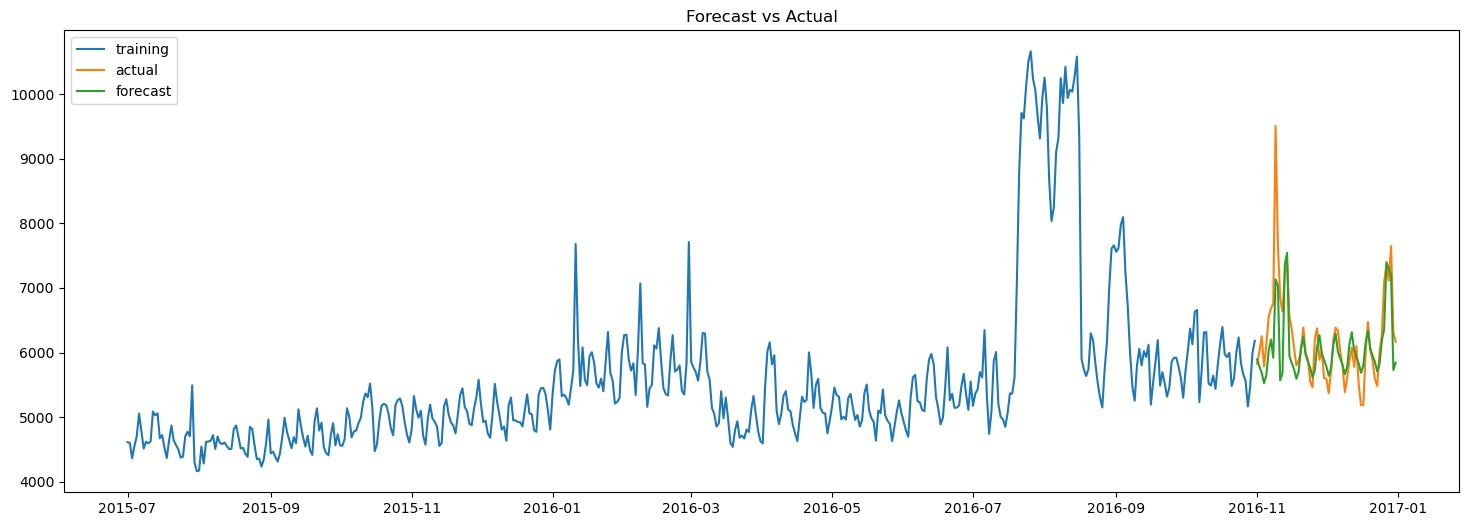

In [303]:
model=sm.tsa.statespace.SARIMAX(train_x["english"],order=(2, 1, 3),seasonal_order=(0,1,2,7),exog=df2[:489].to_numpy())
results=model.fit()

fc=results.forecast(61,dynamic=True,exog=df2[489:].to_numpy())
fc_series = pd.Series(fc)


plt.figure(figsize=(18,6))
plt.plot(train_x["english"], label='training')
plt.plot(test_x["english"], label='actual')
plt.plot(fc_series, label='forecast')

plt.title('Forecast vs Actual')
plt.legend(loc='upper left', fontsize=10)

- we can clearly see SARIMAX does a much better job at fitting to the test data as compared to ARIMA


In [307]:
mape = np.mean(np.abs(fc - test_x["english"].values)/np.abs(test_x["english"].values))

rmse = np.mean((fc - test_x["english"].values)**2)**0.5

print("MAPE of model:",mape)

print("RMSE of model:",rmse)

MAPE of model: 0.051057466588046045
RMSE of model: 489.42451280500944


# Checking hyper parameters for other languages


In [309]:
def sarimax_grid(languages, df_lang, n, param, d_parameter, s_parameter):

    best_param_df  = pd.DataFrame(columns = ['language','p','d', 'q', 'P','D','Q','s','MAPE'])
    for lang in languages:

        print(f'Finding best parameters for {lang}')
        counter = 0
        ts = data_TimeSeries[lang]
        max_MAPE = 100

        for p in param:
            for d in d_param:
                for q in param:
                    for P in param:
                        for D in d_param:
                            for Q in param:
                                for s in s_param:
                                    model = SARIMAX(ts[:-n],order=(p,d,q), seasonal_order=(P, D, Q, s),
                                                    enforce_stationarity=False,exog = df[:n].to_numpy())
                                    model_fit = model.fit()

                                    model_forecast = model_fit.forecast(n, dynamic = True)

                                    #Calculating errors for results
                                    actual = ts.values[-n:]
                                    errors = ts.values[-n:] - model_forecast.values

                                    MAPE = np.mean(np.abs(errors)/ np.abs(actual))

                                    counter += 1

                                    if (MAPE < max_MAPE):
                                        max_MAPE = MAPE
                                        best_p = p
                                        best_d = d
                                        best_q = q
                                        best_P = P
                                        best_D = D
                                        best_Q = Q
                                        best_s = s
                                    else: pass


        best_mape = np.round(max_MAPE, 5)

        print(f'Minimum MAPE for {lang} = {max_MAPE}')
        print(f'Best Parameters are {best_p , best_d, best_q, best_P, best_D, best_Q, best_s}')

        best_param_row = [lang, best_p, best_d, best_q, best_P, best_D, best_Q, best_s, max_MAPE]
        best_param_df.loc[len(best_param_df)] = best_param_row

    return best_param_df

In [317]:
languages = ['chinese','german','japanese','french', 'spanish', 'russian']

n = 30
param = [0,1,2]
d_param = [1]
s_param = [7]

best_param_df = sarimax_grid(languages, data_TimeSeries, n, param, d_parameter, s_parameter)

Finding best parameters for chinese
Minimum MAPE for chinese = 0.036328445767092744
Best Parameters are (1, 1, 0, 1, 1, 2, 7)
Finding best parameters for german
Minimum MAPE for german = 0.06722430198537814
Best Parameters are (0, 1, 1, 0, 1, 1, 7)
Finding best parameters for japanese
Minimum MAPE for japanese = 0.07777658329799024
Best Parameters are (2, 1, 2, 2, 1, 2, 7)
Finding best parameters for french
Minimum MAPE for french = 0.05911832309452758
Best Parameters are (1, 1, 1, 0, 1, 2, 7)
Finding best parameters for spanish
Minimum MAPE for spanish = 0.0821675081873931
Best Parameters are (0, 1, 0, 2, 1, 0, 7)
Finding best parameters for russian
Minimum MAPE for russian = 0.1260333538946827
Best Parameters are (2, 1, 2, 0, 1, 1, 7)


In [330]:
best_param_df

,language,p,d,q,P,D,Q,s,MAPE
0,chinese,1,1,0,1,1,2,7,0.036328
3,french,1,1,1,0,1,2,7,0.059118
1,german,0,1,1,0,1,1,7,0.067224
2,japanese,2,1,2,2,1,2,7,0.077777
4,spanish,0,1,0,2,1,0,7,0.082168
5,russian,2,1,2,0,1,1,7,0.126033


In [331]:
def plot_SARIMAX(languages, df_lang, n, best_param_df):

    for lang in languages:
        p = best_param_df.loc[best_param_df['language'] == lang, ['p']].values[0][0]
        d = best_param_df.loc[best_param_df['language'] == lang, ['d']].values[0][0]
        q = best_param_df.loc[best_param_df['language'] == lang, ['q']].values[0][0]
        P = best_param_df.loc[best_param_df['language'] == lang, ['P']].values[0][0]
        D = best_param_df.loc[best_param_df['language'] == lang, ['D']].values[0][0]
        Q = best_param_df.loc[best_param_df['language'] == lang, ['Q']].values[0][0]
        s = best_param_df.loc[best_param_df['language'] == lang, ['s']].values[0][0]

        ts = df_lang[lang]


        model = SARIMAX(ts[:-n], order =(p,d,q), seasonal_order=(P, D, Q, s), enforce_stationarity=False)
        model_fit = model.fit()

        model_forecast = model_fit.forecast(n, dynamic = True)

        actual = ts.values[-n:]
        errors = ts.values[-n:] - model_forecast.values

        MAPE = np.mean(np.abs(errors)/ np.abs(actual))
        RMSE = np.sqrt(np.mean(errors**2))

        print(f'SARIMAX model for {lang} Time Series')
        print(f'Parameters of Model: ({p},{d},{q}) ({P},{D},{Q},{s})')
        print(f' MAPE of the  Model: {np.round(MAPE,5)}')
        print(f' RMSE of the Model: {np.round(RMSE,3)}')

        ts.index = ts.index.astype('datetime64[ns]')
        model_forecast.index = model_forecast.index.astype('datetime64[ns]')
        plt.figure(figsize = (22,7))
        ts[-60:].plot(label = 'Actual')
        model_forecast[-60:].plot(label='Forecast', style='-o')
        plt.legend(loc="upper left")
        plt.title(f'SARIMAX Model ({p},{d},{q}) ({P},{D},{Q},{s}) : Actual vs Forecasts for {lang}', fontweight = 'bold')
        plt.show()

    return None

SARIMAX model for chinese Time Series
Parameters of Model: (1,1,0) (1,1,2,7)
 MAPE of the  Model: 0.03633
 RMSE of the Model: 15.538


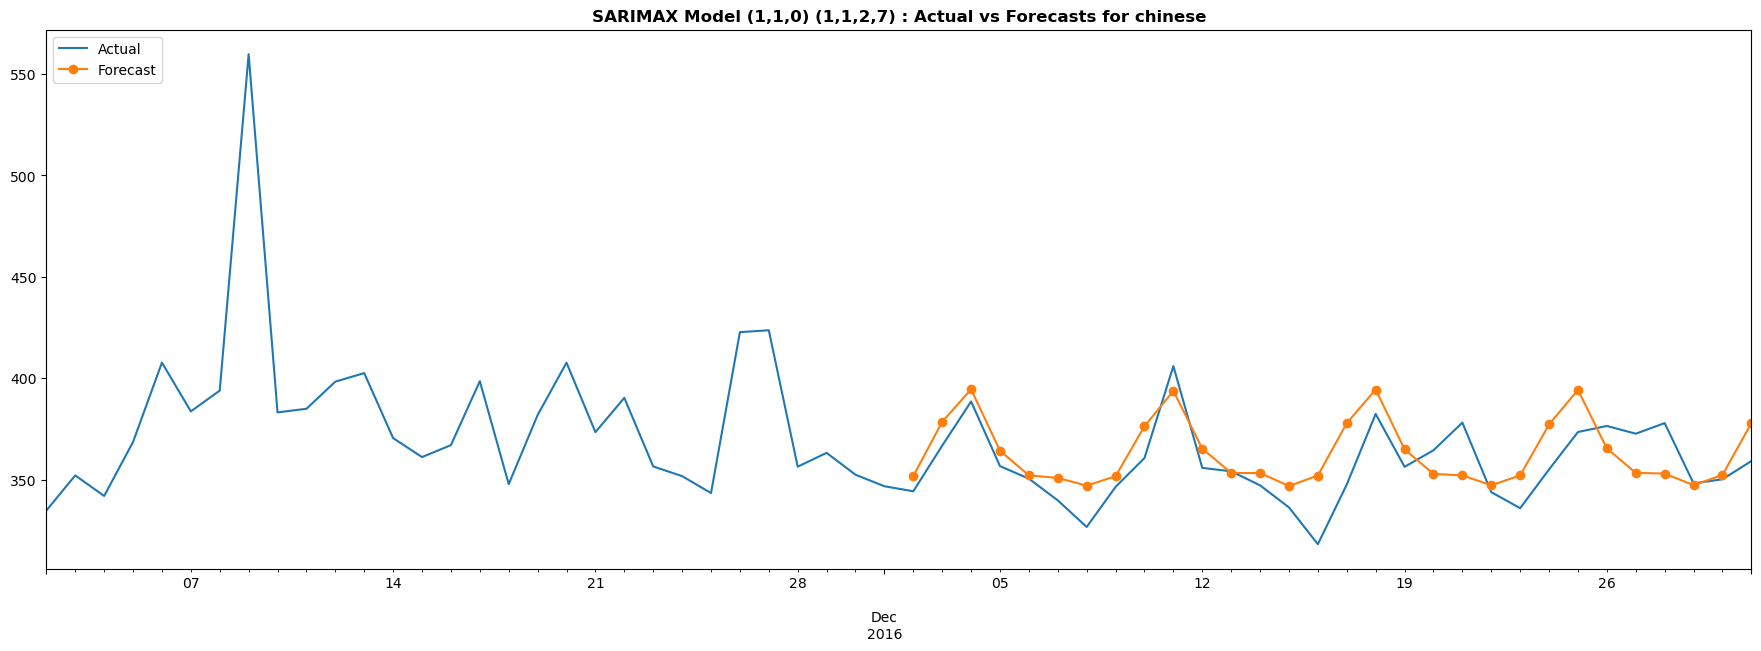

SARIMAX model for german Time Series
Parameters of Model: (0,1,1) (0,1,1,7)
 MAPE of the  Model: 0.06722
 RMSE of the Model: 120.55


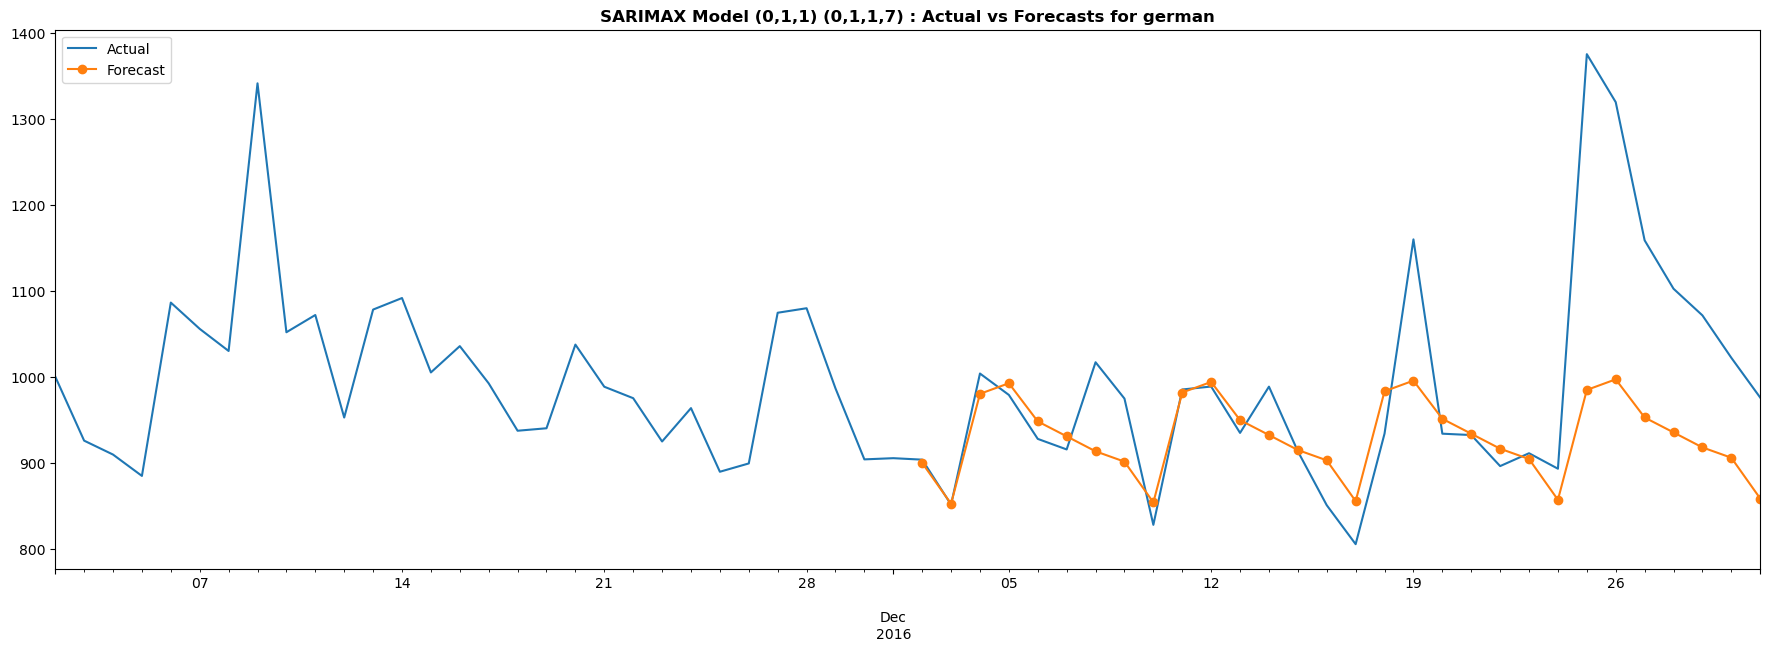

SARIMAX model for japanese Time Series
Parameters of Model: (2,1,2) (2,1,2,7)
 MAPE of the  Model: 0.07778
 RMSE of the Model: 114.941


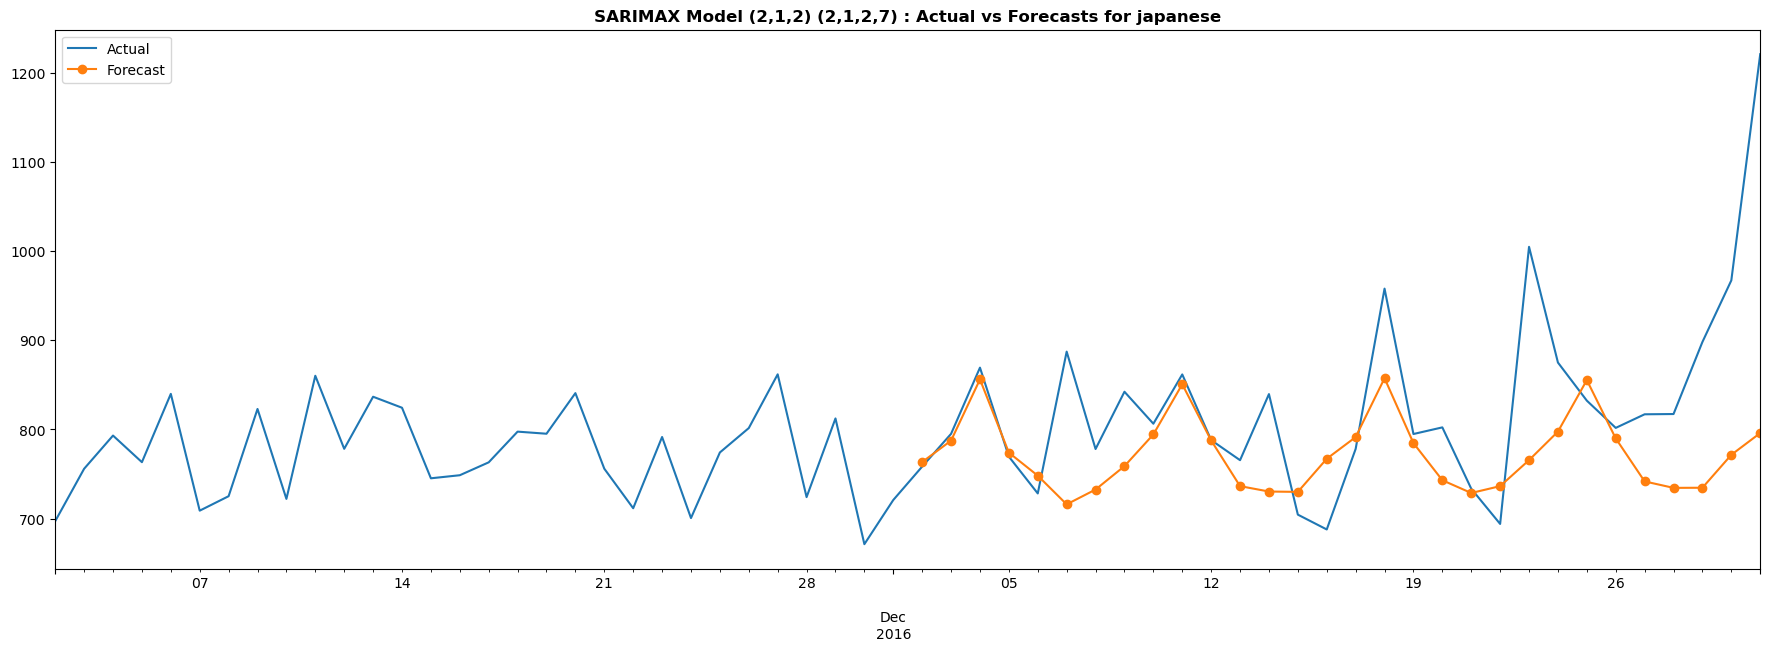

SARIMAX model for french Time Series
Parameters of Model: (1,1,1) (0,1,2,7)
 MAPE of the  Model: 0.05912
 RMSE of the Model: 62.693


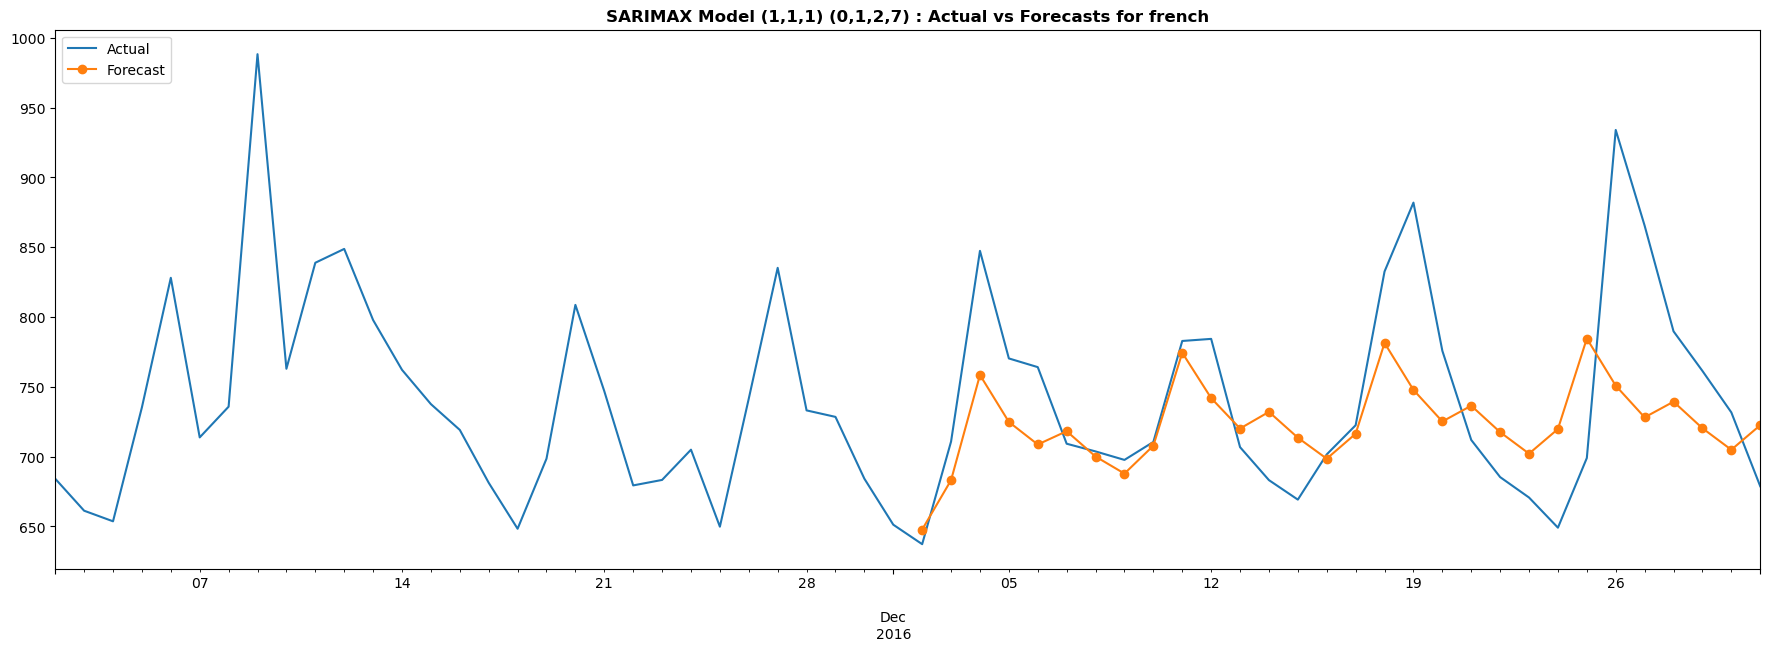

SARIMAX model for spanish Time Series
Parameters of Model: (0,1,0) (2,1,0,7)
 MAPE of the  Model: 0.08217
 RMSE of the Model: 103.464


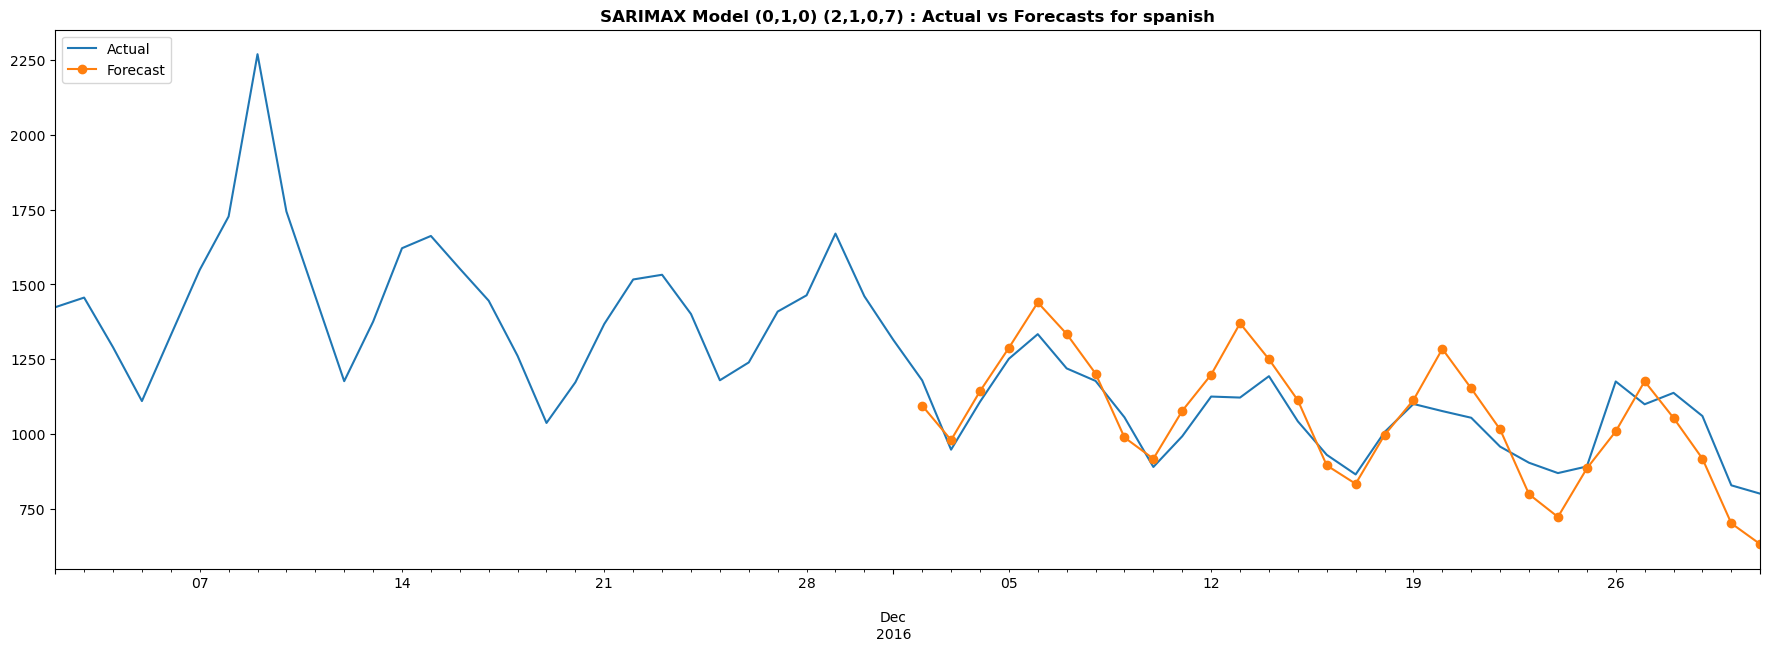

SARIMAX model for russian Time Series
Parameters of Model: (2,1,2) (0,1,1,7)
 MAPE of the  Model: 0.12603
 RMSE of the Model: 136.684


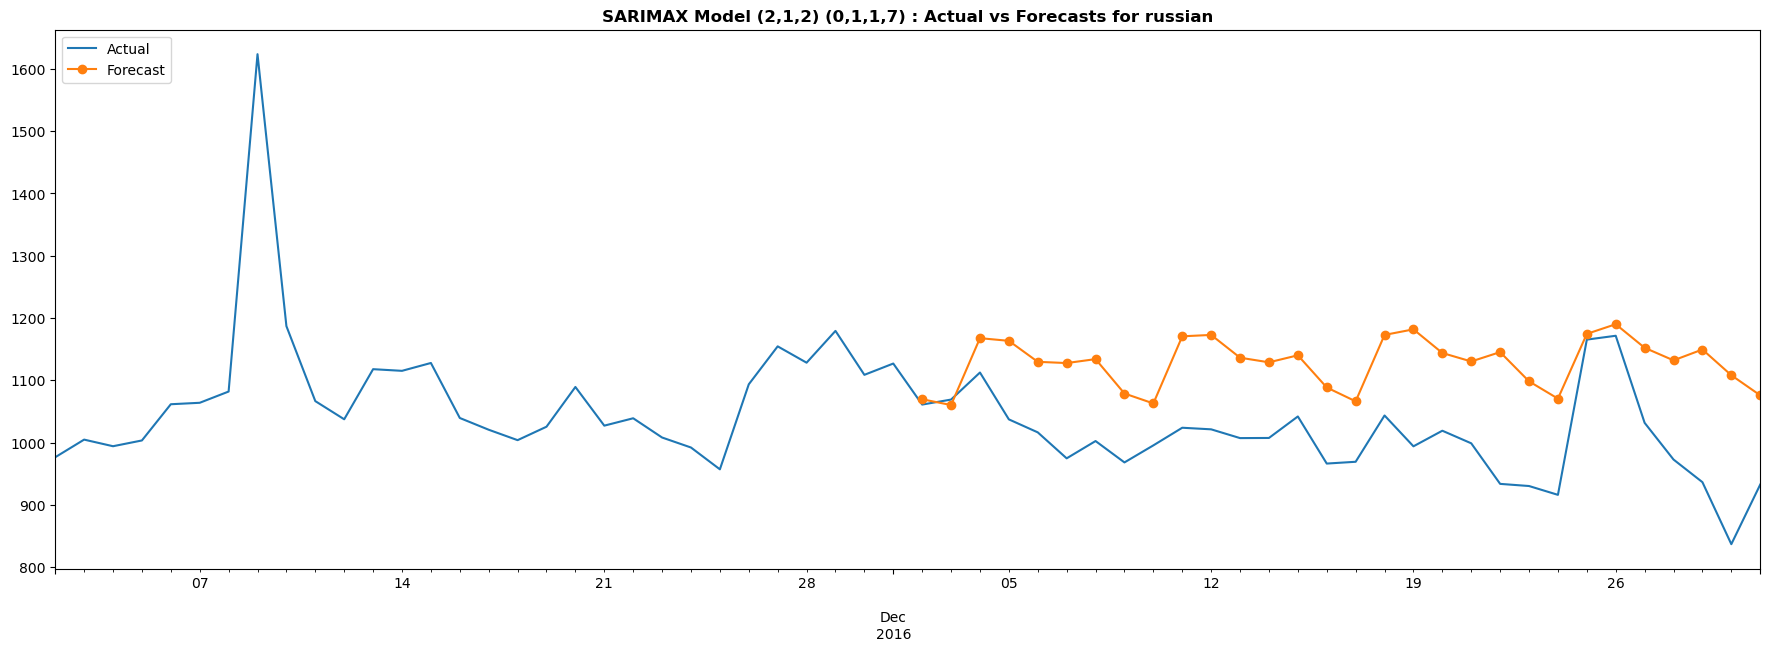

In [334]:
languages = ['chinese','german','japanese','french', 'spanish', 'russian']
n = 30
plot_SARIMAX(languages, data_TimeSeries, n, best_param_df)

# Insights and Recommendations
1) English is the language which has highest views than any other languages. Chinese and Other language have lowest number of views. So maximum ads can be shown on English pages to increase the click rate
<br>

2) Chinese and Other languages have less views and thus limited advertisements must be shown or should be shown to some targeted audience only
<br>

3) Spanish, Russian, French and German have decent amount of views. Ads can be shown to the target audience frequently to increase the click rate
<br>


4) 'All-access' has the highest distribution of Access type. Mobile-web and desktop have almost same distribution which is 25%
<br>

5) 'All agents' contributes to 75.8% of Access origin as compared to spider which is at 24.2%
<br>

6) As per our analysis English is the language which has the highest views, while Chinese has the lowest views. Moreover, below is the comparison: English > Spanish > Russian > German > Japenese > French > Chinese